In [ ]:
# Aurelien Geron의 Hands-on Machine Learning with Scikit-Learn and Tensorlow
# 책은 2판까지 원서로
# 1판은 아마 한국어본 있을 듯

In [ ]:
# Variational Autoencoder
# Generative Adversarial Network
# Diffusion Models

In [ ]:
import sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
# scaling 모든 값이 0에서 1사이에 있도록
X_train_full = X_train_full.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# Stacked (Fully connected) Autoencoder와 Convolutional Autoencoder의 관계
# = Fully connected 신경망과 Convolutional 신경망의 관계
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"), # A
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"), # 이 100이 A에서의 100과 꼭 같아야 하나요? 아님
    # weights tying할 거면 구조를 데칼코마니처럼 만들어줘야 함
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=1,
                         validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 16s 4ms/step - loss: 0.0240 - val_loss: 0.0185


In [ ]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 83ms/step


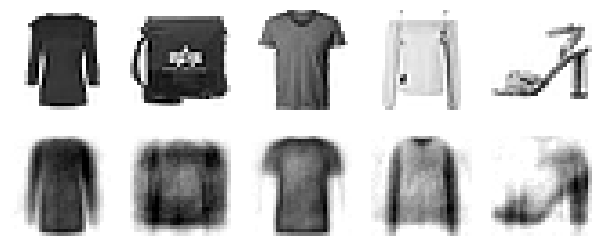

In [ ]:
plot_reconstructions(stacked_ae)
plt.show()

In [ ]:
# Convolutional Autoencoder
# 인코더 쪽은 아는 내용
# 디코더 쪽은 Transposed Convolution이라는 연산에 의존
# https://yeong-jin-data-blog.tistory.com/entry/Autoencoder

In [ ]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"), # 출력 activation map 크기 28
    tf.keras.layers.MaxPool2D(pool_size=2), # 출력이 14
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"), # 출력이 14
    tf.keras.layers.MaxPool2D(pool_size=2), # 출력이 7
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"), # 출력이 7
    tf.keras.layers.MaxPool2D(pool_size=2), # 출력이 3
    tf.keras.layers.GlobalAvgPool2D() # 3 * 3
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation="relu"), # 출력이 7
    tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", # 출력이 14
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding="same"), # 출력이 28
    # 마지막 층에서 activation 함수 거치지 않음
    #
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="mse", optimizer="nadam")
conv_history = conv_ae.fit(X_train, X_train, epochs=1,
                           validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 24s 7ms/step - loss: 0.0314 - val_loss: 0.0230


1/1 [==============================] - 0s 258ms/step


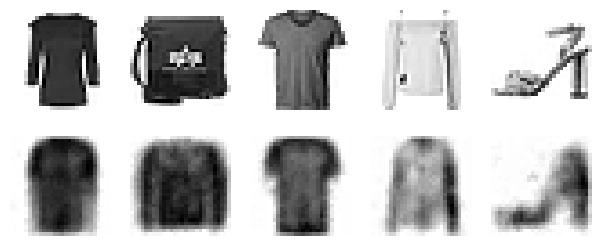

In [ ]:
plot_reconstructions(conv_ae)
plt.show()

In [ ]:
# Variational Autoencoder
# Variational inference / Bayes / ...
# 분포를 parametrize한다 예를 들면 정규분포는 평균과 표준편차로 parametrize됨
class Sampling(tf.keras.layers.Layer): # nn.Module
  def call(self, inputs):
    mean, log_var = inputs
    return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
codings_size = 10
inputs = tf.keras.layers.Input(shape=[28, 28]) # 784에서 codings_size까지 적당히 완만하게 떨어지게끔 각 층 폭 설정
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])
var_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
var_decoder = tf.keras.Model(
    inputs=[decoder_inputs], outputs=[outputs]
)

In [ ]:
_, _, codings = var_encoder(inputs)
reconstructions = var_decoder(codings)

vae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
vae_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1
)
# KL Divergence를 줄이는 손실함수
# KL Divergence? 분포 두개 사이의 dissimilarity (다름)을 재는 도구 중 하나
vae.add_loss(tf.reduce_mean(vae_loss) / 784.) # 픽셀 당 평균 손실
vae.compile(loss="mse", optimizer="nadam")
vae_history = vae.fit(X_train, X_train, epochs=1,
                      validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 15s 7ms/step - loss: 0.0409 - val_loss: 0.0357


1/1 [==============================] - 0s 112ms/step


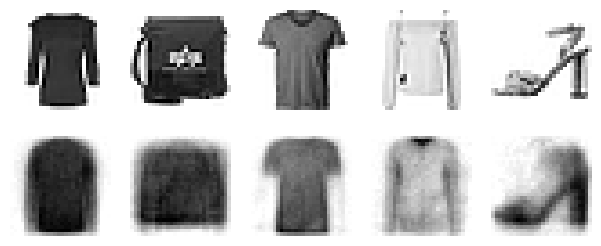

In [ ]:
plot_reconstructions(vae)
plt.show()

In [ ]:
# GAN 트레이닝 루프 안에 넣어서 그림 그려볼 때 쓰기
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
# Generative Adversarial Network
# 생성적 적대적 신경망
# Fully connected GAN
# Convolutional GAN

In [ ]:
noise_dim = 30 # 30차원짜리 노이즈
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid"), # 이진 분류기 설계
])
gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, noise_dim, n_epochs):
  gen, dis = gan.layers
  for epoch in range(n_epochs):
    print("Epoch number: {}".format(epoch))
    for X_batch in dataset:
      noise = tf.random.normal(shape=[batch_size, noise_dim]) # 32, 30
      fake_images = gen(noise) # 32, 28, 28
      X_fake_and_real = tf.concat([fake_images, X_batch], axis=0) # 64, 28, 28
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # 0은 fake; 1이 real
      dis.train_on_batch(X_fake_and_real, y1) # 분류 문제 풀게 하기
      noise = tf.random.normal(shape=[batch_size, noise_dim])
      y2 = tf.constant([[1.]] * batch_size)
      gan.train_on_batch(noise, y2) # y2, 즉 '정답'이 real이라고 알려준 채로 훈련시킴
      # 즉, discriminator가 1이라고 출력하게끔 generator는 학습함
    plot_multiple_images(fake_images.numpy(), 8)
  return

Epoch number: 0
Epoch number: 1


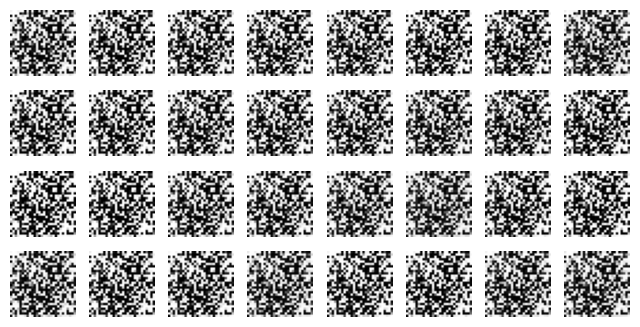

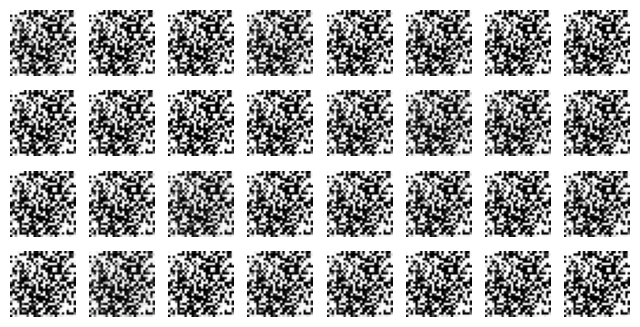

In [ ]:
train_gan(gan, dataset, batch_size, noise_dim, 2)

In [ ]:
# Diffusion models
# 가장 기본적인 형태의 diffusion

In [ ]:
# multi-modal
# 데이터의 모달리티/종류
# 모달리티 -> 텍스트, 이미지, 오디오, 가속도센서, 중력센서, 자기장센서, 프록시미티 센서 (홀 센서), ...

In [ ]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # extra code – for reproducibility
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

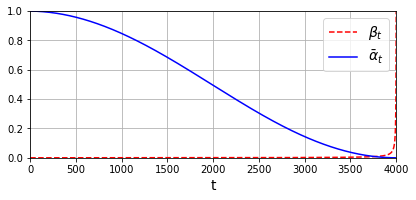

In [ ]:
# extra code – this cell generates and saves Figure 17–21
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
save_fig("variance_schedule_plot")
plt.show()

In [ ]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

In [ ]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # extra code – ensures reproducibility on CPU
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

Original images


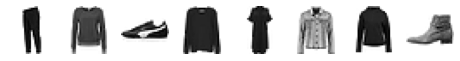

Time steps: [3405  312 3441 1991 2443 1657 3308 1151]
Noisy images


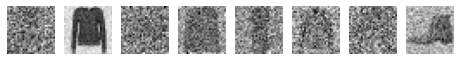

Noise to predict


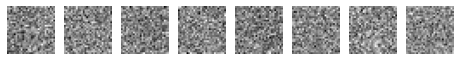

In [ ]:
# extra code – just a quick sanity check

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

In [ ]:
# extra code – implements a custom time encoding layer

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

In [ ]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")

# extra code – adds a ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=100,
                    callbacks=[checkpoint_cb])  # extra code

Epoch 1/100


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 347s 199ms/step - loss: 0.1120 - val_loss: 0.0719
Epoch 2/100


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 352s 205ms/step - loss: 0.0649 - val_loss: 0.0589
Epoch 3/100


INFO:tensorflow:Assets written to: my_diffusion_model/assets


1719/1719 [==============================] - 358s 208ms/step - loss: 0.0550 - val_loss: 0.0539
<<94 more epochs>>
Epoch 98/100
1719/1719 [==============================] - 351s 204ms/step - loss: 0.0377 - val_loss: 0.0375
Epoch 99/100
1719/1719 [==============================] - 407s 237ms/step - loss: 0.0376 - val_loss: 0.0379
Epoch 100/100
1719/1719 [==============================] - 418s 243ms/step - loss: 0.0376 - val_loss: 0.0379
